In [1]:
#import packages
import numpy as np
import json 
import scanpy as sc
from collections import OrderedDict
import scipy 
import pandas as pd

#spectra imports 
from spectra import spectra as spc
from spectra import spectra_util as util
from spectra import K_est as kst

In [2]:
def get_factor_celltypes(adata, obs_key, cellscore_obsm_key = 'SPECTRA_cell_scores'):
    '''
    Assigns Spectra factors to cell types by analyzing the factor cell scores.
    Cell type specific factors will have zero cell scores except in their respective cell type
    
    adata: AnnData , object containing the Spectra output
    obs_key: str , column name in adata.obs containing the cell type annotations
    cellscore_obsm_key: str , key for adata.obsm containing the Spectra cell scores
    
    returns: dict , dictionary of {factor index : 'cell type'}
    '''
    
    #get cellscores
    import pandas as pd
    cell_scores_df = pd.DataFrame(adata.obsm[cellscore_obsm_key])
    cell_scores_df['celltype'] = list(adata.obs[obs_key])
    
    #find global and cell type specific fators
    global_factors_series = (cell_scores_df.groupby('celltype').mean() !=0).all()
    global_factors = [factor for factor in global_factors_series.index if global_factors_series[factor]]
    specific_cell_scores = (cell_scores_df.groupby('celltype').mean()).T[~global_factors_series].T
    specific_factors = {}
    
    for i in set(cell_scores_df['celltype']):
        specific_factors[i]=[factor for factor in specific_cell_scores.loc[i].index if specific_cell_scores.loc[i,factor]]
    
    #inverse dict factor:celltype
    factors_inv = {}
    for i,v in specific_factors.items():
        for factor in v:
            factors_inv[factor]=i
    
    #add global

    for factor in global_factors:
        factors_inv[factor]= 'global'
            
    return factors_inv

## Load gene_set_dictionary

**load a nested dictionary containing global and cell type specific gene sets in the following format**:

Load a gene set annotation dictionary in the following format:

gene_set_dictionary = {'celltype_1':{'gene_set_1':['gene_a', 'gene_b', 'gene_c'], 'gene_set_2':['gene_c','gene_a','gene_e','gene_f']},

'celltype_2':{'gene_set_1':['gene_a', 'gene_b', 'gene_c'], 'gene_set_3':['gene_a', 'gene_e','gene_f','gene_d']},

'celltype_3':{},

'global':"{'gene_set_4':['gene_m','gene_n']}

**Note that if you have a cell type in your adata for which you do not have any gene sets in your gene set annotation dictionary you must include an empty dictionary under that cell type key (like in the example above)**
 
Spectra will use this dictionary to align factors to the input gene sets. Gene sets which apply to only one cell type in the data should be included in the dictionary of that cell type. If a gene sets applies to all cell types in the data, the gene set should be included in the dictionary for 'global'. If a gene set applies to more than one cell type but not all cell types in the data there are two options 1) Include this gene set in each cell type dictionary which will likely result in a separate factor for this gene set in each cell type. OR 2) include this gene set in the 'global' dictionary which will likely result in one factor for this gene set in all cell types. We give additional guidance on the advantages and disadvantages of either approach in the Supplementary Methods of the Spectra paper: https://doi.org/10.1101/2022.12.20.521311 


### default dictionary

We used this dictionary to generate the results in the paper: https://doi.org/10.1101/2022.12.20.521311 

In [3]:
#load the default gene set dictionary from the Spectra paper:
with open("../annotations.json", "rb") as file:
    annotations = json.load(file)

In [4]:
annotations["global"]["all_wnt-beta-catenin-signaling"]

['GNAI1',
 'WNT5B',
 'DVL2',
 'PTCH1',
 'LEF1',
 'HEY2',
 'PSEN2',
 'NKD1',
 'NUMB',
 'AXIN1',
 'SKP2',
 'NOTCH1',
 'JAG1',
 'WNT1',
 'NOTCH4',
 'NCOR2',
 'HEY1',
 'DLL1',
 'WNT6',
 'HDAC5',
 'CTNNB1',
 'DKK1',
 'TP53',
 'FZD1']

## custom dictionaries

Alternatively you can use Spectra with your custom gene set annotation dictionaries. 

**Cytopus Knowledge Base**

We supply the Cytopus knowledge base to construct custom input gene set dictionaries for Spectra. For a tutorial visit the github repository: https://github.com/wallet-maker/cytopus

**External Databases**

To obtain optimal results, we recommend using dedicated gene sets, like from the Cytopus database which are tailored to single cell RNA sequencing data (see Supplementary Methods for details https://doi.org/10.1101/2022.12.20.521311). 

However, Spectra can also use gene set annotation dictionaries from external databases if they can be provided in the format described above.

## Load adata 

In the Spectra paper we use logged scran-normalized leukocyte single cell RNA sequencing data (https://doi.org/10.1101/2022.12.20.521311). We have also used the method with logged median library size normalized RNA sequencing data.

In [5]:
#define data paths
import os
adata_path = os.getcwd()[:-9] + '/data/sample_data.h5ad'#indicate where to find the gene expression AnnData object
obs_key = 'cell_type_annotations' #indicat the column name for the dataframe in adata.obs where to find the cell type labels


In [6]:
#load data
adata = sc.read(adata_path)
adata

AnnData object with n_obs × n_vars = 10000 × 6397
    obs: 'cell_type_annotations'
    var: 'n_cells_by_counts', 'highly_variable'
    uns: 'annotation_SPADE_1_colors', 'cell_type_annotations_colors', 'diffmap_evals', 'draw_graph', 'hvg', 'neighbors', 'pca'
    obsm: 'X_diffmap', 'X_draw_graph_fa', 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

**Important: The cell type labels have to match with the cell type labels in the gene set dictionary**

In [7]:
#test if keys match
adata_labels  = list(set(adata.obs[obs_key]))+['global']#cell type labels in adata object
annotation_labels = list(annotations.keys())
matching_celltype_labels = list(set(adata_labels).intersection(annotation_labels))
if set(annotation_labels)==set(adata_labels):
    print('Cell type labels in gene set annotation dictionary and AnnData object are identical')
if len(annotation_labels)<len(adata_labels):
    print('The following labels are missing in the gene set annotation dictionary:',set(adata_labels)-set(annotation_labels))
if len(adata_labels)<len(annotation_labels):
    print('The following labels are missing in the AnnData object:',set(annotation_labels)-set(adata_labels))

Cell type labels in gene set annotation dictionary and AnnData object are identical


In [8]:
#cell type labels in adata
list(set(adata.obs[obs_key]))

['CD4_T',
 'NK',
 'Treg',
 'B_naive',
 'plasma',
 'mast',
 'ILC3',
 'MDC',
 'DC',
 'B_memory',
 'B_GC',
 'gdT',
 'CD8_T',
 'pDC']

In [9]:
#cell type in gene set annotation dictionary
list(set(annotations.keys()))

['CD4_T',
 'NK',
 'Treg',
 'mast',
 'B_naive',
 'ILC3',
 'plasma',
 'MDC',
 'DC',
 'global',
 'B_memory',
 'B_GC',
 'gdT',
 'CD8_T',
 'pDC']

**if labels do not match adjust the labels either in adata or in annotations**


For example define and map a dictionary mapping the annotations in the adata object to the keys in the gene set annotations dictionary or vice versa. **Note that if you have a cell type in your adata for which you do not have any gene sets in your gene set annotation dictionary you must include an empty dictionary under that cell type key**.  Afterwards confirm that the matching has worked:

In [10]:
#test if keys match
adata_labels  = list(set(adata.obs[obs_key]))+['global']#cell type labels in adata object
annotation_labels = list(annotations.keys())
matching_celltype_labels = list(set(adata_labels).intersection(annotation_labels))
if len(matching_celltype_labels)==len(adata_labels) and len(matching_celltype_labels)== len(annotation_labels):
    print('Cell type labels in gene set annotation dictionary and AnnData object are identical')
if len(annotation_labels)<len(adata_labels):
    print('The following labels are missing in the gene set annotation dictionary:',set(adata_labels)-set(annotation_labels))
if len(adata_labels)<len(annotation_labels):
    print('The following labels are missing in the AnnData object:',set(annotation_labels)-set(adata_labels))

Cell type labels in gene set annotation dictionary and AnnData object are identical


# Fit Spectra model 

**General comments**

Spectra is very memory and cpu intense. 

The here-provided dataset can be run on most computers. For bigger datasets you would want to run this in non-interactive mode, as runtime can be 1-2 days for a dataset of ca 200,000 cells with  250 factors and 10 cell types. Run time mainly depends on the number of cell types in your data.

An example hardware you could run a 200,000 cell, 10 cell type, 250 factor dataset on would be:

16 cpus Intel Xeon Gold
256 GB RAM

**Parameters**

**adata** : *AnnData* object containing cell_type_key with log count data stored in .X

**gene_set_dictionary**:*dict* or *OrderedDict()* maps cell types to gene set names to gene sets ; if use_cell_types == False then maps gene set names to gene sets ; must contain "global" key in addition to every unique cell type under .obs.<cell_type_key>

**L** : *dict*, *OrderedDict()*, int , NoneType number of factors per cell type ; if use_cell_types == False then int. Else dictionary. If None then match factors to number of gene sets (recommended) 
            
**use_highly_variable** : *bool*  if True, then uses highly_variable_genes

**cell_type_key**: *str*
            cell type key, must be under adata.obs.<cell_type_key> . If use_cell_types == False, this is ignored
            
**use_weights**: *bool*
            if True, edge weights are estimated based on graph structure and used throughout training
            
**lam**: *float* 
            lambda parameter of the model. weighs relative contribution of graph and expression loss functions
            
**delta**: *float*
            delta parameter of the model. lower bounds possible gene scaling factors so that maximum ratio of gene scalings
            cannot be too large 
            
**kappa**: *float* or *None*
            if None, estimate background rate of 1s in the graph from data
            
**rho**: *float* or *None* 
            if None, estimate background rate of 0s in the graph from data
            
**use_cell_types** : *bool*
            if True then cell type label is used to fit cell type specific factors. If false then cell types are ignored

**n_top_vals** : *int*
            number of top markers to return in markers dataframe

**determinant_penalty** : *float* 
            determinant penalty of the attention mechanism. If set higher than 0 then sparse solutions of the attention weights
            and diverse attention weights are encouraged. However, tuning is crucial as setting too high reduces the selection 
            accuracy because convergence to a hard selection occurs early during training [todo: annealing strategy]

**filter_sets** : *bool* 
            whether to filter the gene sets based on coherence

**kwargs** : (num_epochs = 10000, lr_schedule = [...], verbose = False)
            arguments to .train(), maximum number of training epochs, learning rate schedule and whether to print changes in
            learning rate
            
**Returns**: *SPECTRA_Model* object [after training]
     
**In place**: adds 1. factors, 2. cell scores, 3. vocabulary, and 4. markers as attributes in .obsm, .var, .uns   

In [11]:
#fit the model (We will run this with only 2 epochs to decrease runtime in this tutorial)
model = spc.est_spectra(adata = adata, gene_set_dictionary = annotations, 
                        use_highly_variable = True, cell_type_key = "cell_type_annotations", 
                        use_weights = True, lam = 0.1, 
                        delta=0.001,kappa = 0.00001, rho = 0.00001, 
                        use_cell_types = True, n_top_vals = 25, 
                        num_epochs=2 #for demonstration purposes we will only run 2 epochs, we recommend 10,000 epochs
                       )

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.70s/it]


In [12]:
#this is the model file which includes all outputs
dir(model)

['B_diag',
 'L',
 '_SPECTRA_Model__B_diag',
 '_SPECTRA_Model__eta_matrices',
 '_SPECTRA_Model__store_parameters',
 '_SPECTRA_Model__store_parameters_no_celltypes',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'cell_scores',
 'delta',
 'eta_matrices',
 'factors',
 'gene_scalings',
 'initialize',
 'internal_model',
 'kappa',
 'lam',
 'load',
 'matching',
 'return_cell_scores',
 'return_eta',
 'return_eta_diag',
 'return_factors',
 'return_gene_scalings',
 'return_graph',
 'return_kappa',
 'return_rho',
 'rho',
 'save',
 'train',
 'use_cell_types']

In [13]:
#save the model file
model_save_path = 'example_model'
model.save(model_save_path)
print('Saved Spectra model to:',model_save_path)

Saved Spectra model to: example_model


In [14]:
#the adata will contain the most important outputs from the Spectra model 
adata

AnnData object with n_obs × n_vars = 10000 × 6397
    obs: 'cell_type_annotations'
    var: 'n_cells_by_counts', 'highly_variable', 'spectra_vocab'
    uns: 'annotation_SPADE_1_colors', 'cell_type_annotations_colors', 'diffmap_evals', 'draw_graph', 'hvg', 'neighbors', 'pca', 'SPECTRA_factors', 'SPECTRA_markers', 'SPECTRA_L'
    obsm: 'X_diffmap', 'X_draw_graph_fa', 'X_pca', 'X_tsne', 'X_umap', 'SPECTRA_cell_scores'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [15]:
#find the markers under adata.uns['SPECTRA_markers']
adata.uns['SPECTRA_markers']

array([['ABCB4', 'ABCC3', 'EXOSC1', ..., 'CD2', 'CLEC16A', 'PSMD8'],
       ['BLVRB', 'ALAD', 'SLC46A1', ..., 'GSTM2', 'ALG2', 'ANAPC7'],
       ['PTGER4', 'OLR1', 'CCRL2', ..., 'BCL6', 'NAMPT', 'TNFRSF9'],
       ...,
       ['TCF7', 'RNF145', 'ID2', ..., 'PPM1D', 'HIST1H2AC', 'ESCO2'],
       ['SERPINF1', 'PLD4', 'LILRA4', ..., 'BCL10', 'YPEL1', 'IRF7'],
       ['IGLL5', 'SLC2A1', 'LMAN1', ..., 'TXNDC11', 'PLA2G5', 'PIM2']],
      dtype=object)

In [16]:
#find the factors under adata.uns['SPECTRA_factors'] 
adata.uns['SPECTRA_factors']

array([[1.31596200e-13, 3.62202172e-13, 2.84737746e-14, ...,
        2.20326177e-14, 7.67681034e-13, 3.05720069e-12],
       [3.89500993e-14, 9.49888713e-12, 3.10005081e-14, ...,
        1.83253195e-14, 2.14872656e-13, 4.46449468e-12],
       [1.73114933e-13, 2.12047902e-12, 1.83526596e-14, ...,
        1.44541943e-14, 3.11489111e-13, 7.15271451e-13],
       ...,
       [1.29342684e-13, 2.19983938e-12, 3.16174690e-12, ...,
        1.44547498e-13, 1.49521903e-12, 3.30411275e-12],
       [8.11082903e-02, 3.40785174e-02, 6.41057719e-02, ...,
        5.31429201e-02, 1.54611392e-01, 4.89093306e-02],
       [1.06434731e-01, 6.41404312e-02, 9.39673383e-02, ...,
        5.65699062e-03, 5.53130237e-02, 1.28957081e-01]])

In [17]:
#it also includes a dictionary of the factor numbers per cell type
adata.uns['SPECTRA_L']

{'global': 148,
 'B_memory': 5,
 'CD4_T': 12,
 'CD8_T': 7,
 'DC': 3,
 'MDC': 6,
 'Treg': 2,
 'mast': 2,
 'pDC': 2,
 'B_GC': 1,
 'NK': 1,
 'ILC3': 1,
 'B_naive': 1,
 'plasma': 1,
 'gdT': 1}

In [18]:
#get factor celltype labels (the cell type will likely be provided directly by the model in future versions)
celltype_dict = get_factor_celltypes(adata, obs_key= obs_key, cellscore_obsm_key = 'SPECTRA_cell_scores')
celltype_dict

{155: 'CD4_T',
 156: 'CD4_T',
 157: 'CD4_T',
 158: 'CD4_T',
 159: 'CD4_T',
 160: 'CD4_T',
 161: 'CD4_T',
 162: 'CD4_T',
 163: 'CD4_T',
 164: 'CD4_T',
 165: 'CD4_T',
 166: 'CD4_T',
 184: 'NK',
 185: 'Treg',
 186: 'Treg',
 154: 'B_naive',
 192: 'plasma',
 188: 'mast',
 189: 'mast',
 177: 'ILC3',
 178: 'MDC',
 179: 'MDC',
 180: 'MDC',
 181: 'MDC',
 182: 'MDC',
 183: 'MDC',
 174: 'DC',
 175: 'DC',
 176: 'DC',
 149: 'B_memory',
 150: 'B_memory',
 151: 'B_memory',
 152: 'B_memory',
 153: 'B_memory',
 148: 'B_GC',
 187: 'gdT',
 167: 'CD8_T',
 168: 'CD8_T',
 169: 'CD8_T',
 170: 'CD8_T',
 171: 'CD8_T',
 172: 'CD8_T',
 173: 'CD8_T',
 190: 'pDC',
 191: 'pDC',
 0: 'global',
 1: 'global',
 2: 'global',
 3: 'global',
 4: 'global',
 5: 'global',
 6: 'global',
 7: 'global',
 8: 'global',
 9: 'global',
 10: 'global',
 11: 'global',
 12: 'global',
 13: 'global',
 14: 'global',
 15: 'global',
 16: 'global',
 17: 'global',
 18: 'global',
 19: 'global',
 20: 'global',
 21: 'global',
 22: 'global',
 23: 'gl

In [19]:
#so you can construct a dataframe for the factor gene weights

#include cell type specificity as a prefix into the index
index_labels = [celltype_dict[x]+'_'+str(x) for x in range(adata.uns['SPECTRA_factors'].shape[0])]
gene_weights = pd.DataFrame(adata.uns['SPECTRA_factors'], 
                            index= index_labels,
                            columns=adata.var[adata.var['spectra_vocab']].index)
gene_weights

,KCNC3,HACD1,FAM214A,TBCD,AC124312.1,PLAGL2,CD40LG,AC022182.1,USP53,PILRA,...,GNA14,CCL3L1,BAG3,CDC42EP3,RANBP1,FDFT1,HACD4,FCGR3A,AZGP1,SLC35A1
global_0,1.315962e-13,3.622022e-13,2.847377e-14,1.208714e-14,4.833647e-14,2.426432e-13,4.058334e-14,1.775727e-13,3.201211e-14,1.657777e-12,...,3.422316e-12,1.591803e-13,1.319593e-14,9.587081e-14,8.658929e-12,2.852575e-13,5.568383e-12,2.203262e-14,7.676810e-13,3.057201e-12
global_1,3.895010e-14,9.498887e-12,3.100051e-14,1.119036e-14,6.179723e-14,1.156453e-13,1.184474e-13,9.624161e-14,1.391134e-14,3.418276e-13,...,2.673801e-12,8.498979e-14,9.956824e-14,2.898360e-13,5.048414e-13,2.432599e-13,4.607450e-12,1.832532e-14,2.148727e-13,4.464495e-12
global_2,1.731149e-13,2.120479e-12,1.835266e-14,4.592507e-14,1.214657e-13,1.425912e-13,1.432088e-13,6.406029e-13,8.159139e-15,1.892984e-12,...,9.478932e-14,1.135910e-13,2.460631e-14,1.980475e-14,1.136117e-11,1.140904e-13,1.084928e-11,1.445419e-14,3.114891e-13,7.152715e-13
global_3,1.298645e-13,2.163457e-12,1.659499e-14,2.793237e-14,9.622064e-14,3.166747e-13,3.992574e-14,1.191078e-13,7.322110e-15,5.478343e-13,...,4.252267e-12,3.210866e-13,3.005710e-14,4.205504e-14,5.476462e-12,1.827729e-12,8.270066e-13,1.127011e-14,4.917321e-13,9.726017e-12
global_4,7.546779e-14,5.824665e-13,2.115830e-14,1.159428e-14,3.301775e-13,6.378982e-14,1.307480e-14,1.213857e-13,2.092713e-14,6.726072e-13,...,5.597295e-13,4.287074e-14,4.525852e-14,9.586149e-14,3.102554e-12,4.751737e-13,3.953993e-12,2.358589e-14,3.006534e-13,9.176212e-13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
mast_188,8.502194e-14,1.659709e-12,9.443578e-14,4.035805e-12,2.670536e-13,3.967011e-12,1.161127e-12,1.967093e-12,3.119743e-13,6.526549e-13,...,2.152557e-13,2.855768e-13,1.129534e-12,3.077384e-13,2.988644e-13,6.012294e-13,3.973565e-13,1.282458e-13,8.556303e-14,1.979882e-14
mast_189,3.304884e-02,5.772733e-02,1.004382e-02,1.485746e-01,2.838442e-02,1.087236e-01,6.291950e-02,3.906042e-02,4.250476e-02,4.953029e-02,...,3.777091e-02,1.750654e-02,1.513258e-01,6.833376e-02,5.287058e-02,1.057606e-01,3.654801e-02,1.993346e-02,5.016799e-02,8.608635e-03
pDC_190,1.293427e-13,2.199839e-12,3.161747e-12,5.706448e-13,1.209804e-12,2.440732e-13,1.486447e-12,6.475712e-14,5.969335e-13,7.849683e-14,...,4.749574e-13,7.334836e-13,1.616479e-12,5.278314e-13,2.725544e-13,2.221665e-13,1.061718e-13,1.445475e-13,1.495219e-12,3.304113e-12
pDC_191,8.110829e-02,3.407852e-02,6.410577e-02,7.082539e-02,3.194065e-02,1.401025e-02,1.948124e-02,2.458199e-02,7.952219e-02,1.970563e-02,...,6.848859e-03,3.425763e-02,5.530202e-02,2.567195e-02,9.059734e-02,6.231893e-02,2.432388e-02,5.314292e-02,1.546114e-01,4.890933e-02


In [20]:
#find the cell scores under adata.obsm['SPECTRA_cellscores']
adata.obsm['SPECTRA_cell_scores']

array([[4.02929293e-06, 3.48913074e-05, 8.40527029e-04, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [6.95412247e-06, 6.69155144e-06, 1.17343229e-03, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [8.76638631e-05, 3.25264382e-05, 5.54222779e-04, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [2.20961976e-06, 1.28742779e-05, 1.03179786e-03, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [8.33497500e-05, 8.74046398e-05, 1.01903002e-03, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [4.61478669e-06, 2.99672755e-05, 4.78466619e-04, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [21]:
#construct a dataframe for the cell scores

#include cell type specificity as a prefix into the column names
column_labels = [celltype_dict[x]+'_'+str(x) for x in range(adata.obsm['SPECTRA_cell_scores'].shape[1])]
cell_scores = pd.DataFrame(adata.obsm['SPECTRA_cell_scores'], 
                            index= adata.obs_names,
                            columns=column_labels)
cell_scores

,global_0,global_1,global_2,global_3,global_4,global_5,global_6,global_7,global_8,global_9,...,MDC_183,NK_184,Treg_185,Treg_186,gdT_187,mast_188,mast_189,pDC_190,pDC_191,plasma_192
0,0.000004,0.000035,0.000841,0.000392,0.000019,0.000296,0.000012,0.000018,3.550238e-06,0.000137,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000007,0.000007,0.001173,0.000436,0.000004,0.000025,0.000063,0.000146,2.939069e-06,0.001203,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000088,0.000033,0.000554,0.003107,0.000111,0.000595,0.000005,0.000052,9.437428e-06,0.000195,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000005,0.000162,0.001353,0.000238,0.000066,0.000479,0.000125,0.000013,5.407666e-06,0.002750,...,0.076286,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000015,0.000031,0.001107,0.000101,0.000035,0.000188,0.000179,0.000005,9.179370e-06,0.000112,...,0.000000,0.0,0.000147,0.036526,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.000017,0.000107,0.001270,0.001365,0.000012,0.000338,0.000024,0.000027,1.041387e-06,0.000403,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
9996,0.000037,0.000018,0.000149,0.000063,0.000048,0.000032,0.000081,0.000002,1.722202e-05,0.000475,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
9997,0.000002,0.000013,0.001032,0.000121,0.000038,0.000020,0.000026,0.000014,4.195511e-07,0.000142,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
9998,0.000083,0.000087,0.001019,0.000331,0.000036,0.000177,0.000047,0.000050,9.034912e-06,0.000046,...,0.111681,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


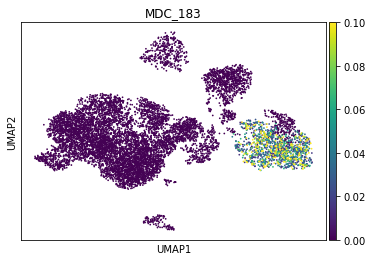

In [22]:
#visualize factor cell scores (this is poorly fitted bc we only ran 2 epochs)
factor_of_interest = 'MDC_183'
adata.obs[factor_of_interest] = cell_scores[factor_of_interest].astype(float)
sc.pl.umap(adata,color=factor_of_interest,vmax=0.1)

In [23]:
#save the adata
adata_save_path = 'adata_spectra.h5ad'#where to save the adata to
adata.write(adata_save_path)
print('Saved adata to:',adata_save_path)

Saved adata to: adata_spectra.h5ad
